<a href="https://colab.research.google.com/github/joaqgonzar/pCCA-Hippocampus/blob/main/load_dataset_dandi_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example dataset notebook
## Gonzalez & Vöröslakos et al 2026
The dataset contains:
1) Ephys recordings (e.g., Neuropixels 2.0 recordings across CA3, CA1, and RSC).
2) Behavioral data (e.g.,novel linear maze, Pre/Post Sleep)

see https://dandiarchive.org/dandiset/001695 for the full repository

In [1]:
!pip install -U dandi pynwb h5py remfile

import os
import pandas as pd
from matplotlib import pyplot as plt
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
from pynwb import NWBHDF5IO
import numpy as np

In [2]:
# Get a fresh URL
dandiset_id = '001695'
filepath = 'sub-M02/sub-M02_ses-20240313T100000_behavior+ecephys.nwb'

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [3]:
# Wrap the URL in a remfile object
r_file = remfile.File(s3_url)
h5_file = h5py.File(r_file, 'r')

# Open NWB and extract
with NWBHDF5IO(file=h5_file, mode='r', load_namespaces=True) as io:
    nwbfile = io.read()

    # We use a list comprehension but call .tolist() or direct index
    # to ensure we get the data out before the file closes
    num_units = len(nwbfile.units)

    print("Streaming data...")
    # Using 'get_unit_spike_times' is the safest way to access the ragged arrays
    # while the file handle is open.

    cell_areas = nwbfile.units['cell_area'][:]
    cell_types = nwbfile.units['cell_type'][:]

    # Filter for area
    ca1_indices = np.where(cell_areas == 'CA1')[0]
    ca3_indices = np.where(cell_areas == 'CA3')[0]
    rsc_indices = np.where(cell_areas == 'RSC')[0]

    spike_times_ca1 = [nwbfile.units.get_unit_spike_times(i) for i in ca1_indices]
    spike_times_ca3 = [nwbfile.units.get_unit_spike_times(i) for i in ca3_indices]
    spike_times_rsc = [nwbfile.units.get_unit_spike_times(i) for i in rsc_indices]


    # Extract behavior
    behavior_module = nwbfile.processing['behavior']

    # Extract the 2D position data (x, y coordinates) from the 'Position' spatial series and convert to a numpy array.
    position = np.array(behavior_module['AnimalPosition']['Position'].data)

    # Extract the speed data from the 'Speed' timeseries and convert to a numpy array.
    speed = np.array(behavior_module['Speed'].data)

    # Extract the timestamps corresponding to each position/speed data point.
    timestamps = np.array(behavior_module['AnimalPosition']['Position'].timestamps)



    # Extract LFP
    ecephys_module = nwbfile.processing['ecephys']
    lfp_container = ecephys_module.get('LFP')

    # We named the LFP ElectricalSeries 'Best_Ripple_LFP'
    lfp_series = lfp_container.get_electrical_series('Best_Ripple_channel_LFP_CA1')

    lfp_traces = lfp_series.data[:] # Use [:] to load the data into memory

    # B. The Timestamps (Time in seconds)
    srate_lfp = lfp_series.rate
    starting_time = lfp_series.starting_time
    lfp_times = np.arange(starting_time,lfp_traces.shape[0]/srate_lfp,1/srate_lfp)


    # Extract Sleep
    # Access the 'SleepStates' interval table from the NWB file.
    sleep_states = nwbfile.intervals['SleepStates']

    # Extract the array of state labels ('WAKE', 'NREM', 'REM') and times into numpy arrays.
    states = np.array(sleep_states['state'])
    start_time = np.array(sleep_states['start_time'])
    stop_time = np.array(sleep_states['stop_time'])
    nrem_index = states == 'NREM'
    rem_index = states == 'REM'
    wake_index = states == 'WAKE'

    # Extract ripple times
    ripples_index = states == 'Ripple'
    start_time_ripples = start_time[ripples_index]
    stop_time_ripples = stop_time[ripples_index]


print(f"Successfully retrieved data!")

Streaming data...
Successfully retrieved data!


## Visualizing Neuronal Spiking Activity Across Brain Regions


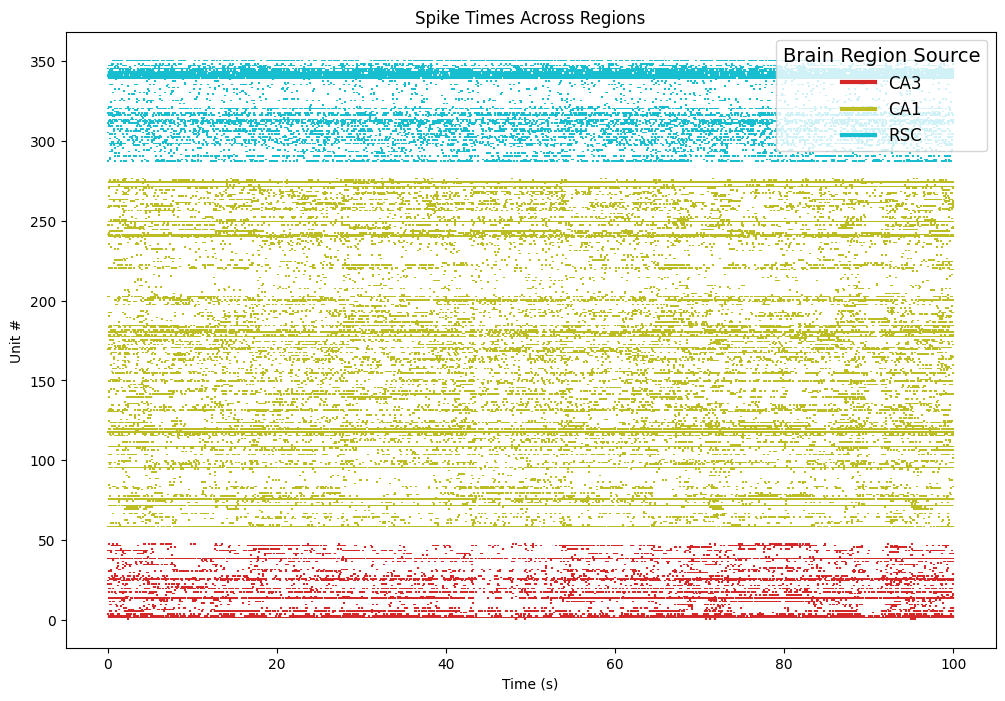

In [4]:
plt.figure(figsize = (12,8))

# Define the time window (from 0 to 100 seconds) for which to display spikes.
# Loop through each neuron (unit) identified in each CA3 region.
# Select only the spikes that fall within the specified time window.

time_window_plot = [0,100]

plot_count = 0

for spikes in spike_times_ca3:
    spikes_plot = spikes[(spikes>time_window_plot[0])*(spikes<time_window_plot[1])]
    plt.vlines(spikes_plot,plot_count,plot_count+1, color = 'tab:red')
    plot_count = plot_count+1

plot_count = plot_count+10

for spikes in spike_times_ca1:
    spikes_plot = spikes[(spikes>time_window_plot[0])*(spikes<time_window_plot[1])]
    plt.vlines(spikes_plot,plot_count,plot_count+1, color = 'tab:olive')
    plot_count = plot_count+1

plot_count = plot_count+10

for spikes in spike_times_rsc:
    spikes_plot = spikes[(spikes>time_window_plot[0])*(spikes<time_window_plot[1])]
    plt.vlines(spikes_plot,plot_count,plot_count+1, color = 'tab:cyan')
    plot_count = plot_count+1


import matplotlib.lines as mlines
# Create a proxy artist (a red line) to represent neurons in the legend.
ca3_handle = mlines.Line2D([], [], color='tab:red', linewidth=3, label='CA3')
ca1_handle = mlines.Line2D([], [], color='tab:olive', linewidth=3, label='CA1')
rsc_handle = mlines.Line2D([], [], color='tab:cyan', linewidth=3, label='RSC')

plt.legend(handles=[ca3_handle, ca1_handle, rsc_handle],
           loc='upper right',
           title='Brain Region Source',
           fontsize=12,
           title_fontsize=14)

plt.title('Spike Times Across Regions')
plt.ylabel('Unit #')
plt.xlabel('Time (s)')
plt.show()

## Accessing Behavioral Data

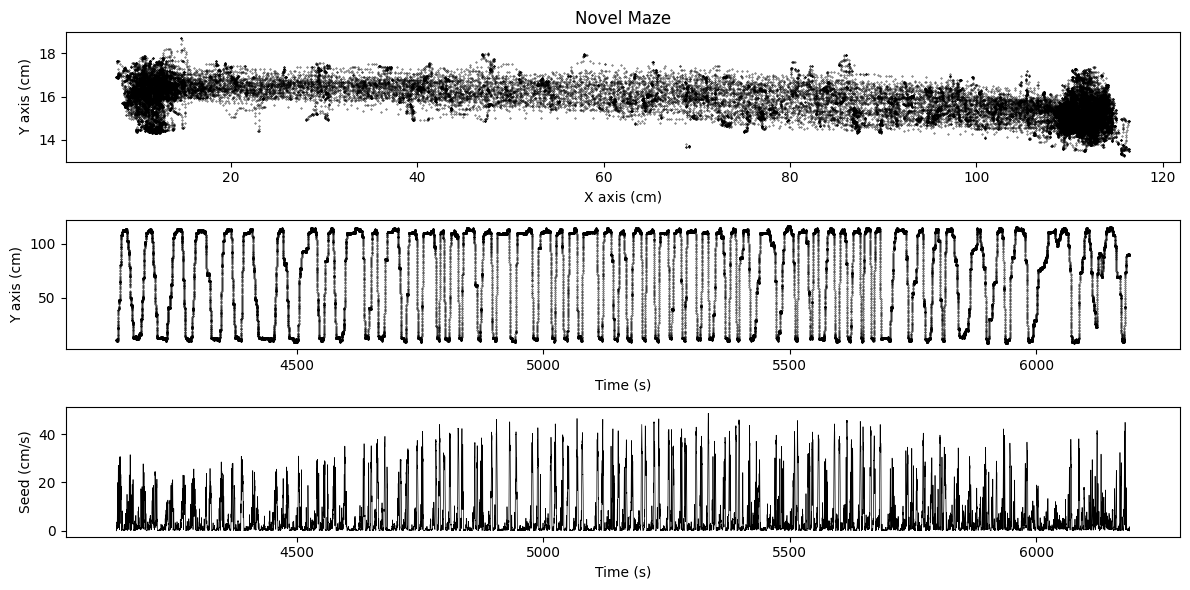

In [5]:
plt.figure(figsize = (12,6))

plt.subplot(311)
plt.scatter(position[:,0],position[:,1], s = 0.1, color = 'black')
plt.ylabel('Y axis (cm)')
plt.xlabel('X axis (cm)')
plt.title('Novel Maze')

plt.subplot(312)
plt.scatter(timestamps,position[:,0], s = 0.1, color = 'black')
plt.ylabel('Y axis (cm)')
plt.xlabel('Time (s)')

plt.subplot(313)
plt.plot(timestamps,speed, color = 'black', linewidth = 0.5)
plt.ylabel('Seed (cm/s)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Visualizing Sleep States (Hypnogram)

([<matplotlib.axis.YTick at 0x7d64854ce960>,
 [Text(0, 0.5, 'Wake'), Text(0, 1.5, 'NREM'), Text(0, 2.5, 'REM')])

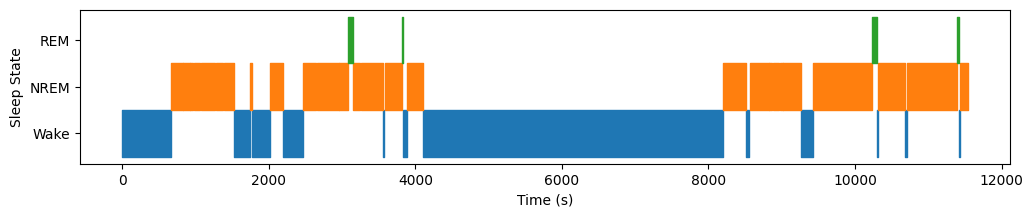

In [6]:
start_time_nrem = start_time[nrem_index]
stop_time_nrem = stop_time[nrem_index]

start_time_rem = start_time[rem_index]
stop_time_rem = stop_time[rem_index]

start_time_wake = start_time[wake_index]
stop_time_wake = stop_time[wake_index]

plt.figure(figsize = (12,2))

# Loop through each state epoch using its start and stop times and plot it.
for start,stop in zip(start_time_wake,stop_time_wake):
    plt.fill_between([start,stop],[0,0],[1,1], color = 'tab:blue')

for start,stop in zip(start_time_nrem,stop_time_nrem):
    plt.fill_between([start,stop],[1,1],[2,2], color = 'tab:orange')

for start,stop in zip(start_time_rem,stop_time_rem):
    plt.fill_between([start,stop],[2,2],[3,3], color = 'tab:green')

plt.ylabel('Sleep State')
plt.xlabel('Time (s)')
plt.yticks([0.5,1.5,2.5],labels = ['Wake', 'NREM', 'REM'])

## Visualizing Sharp-Wave Ripple (SWR) Events

([], [])

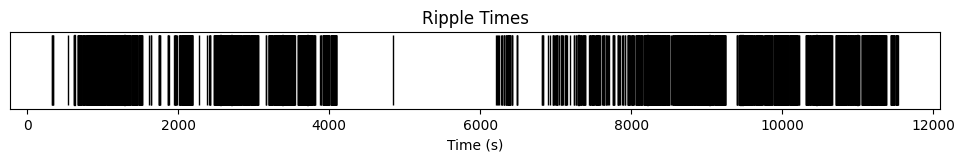

In [7]:
plt.figure(figsize = (12,1))

for start,stop in zip(start_time_ripples,stop_time_ripples):
    plt.fill_between([start,stop],[0,0],[1,1], color = 'black')

plt.title('Ripple Times')
plt.xlabel('Time (s)')
plt.yticks([])

## Accessing the LFP signal
This cell extracts the LFP used for detecting SWR.

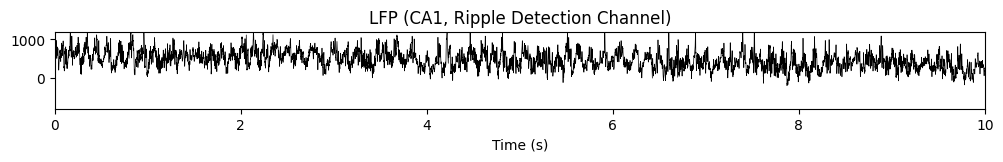

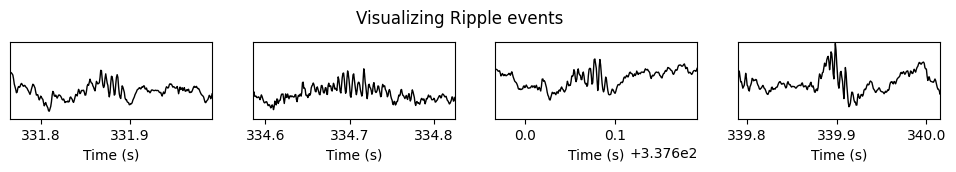

In [8]:
# B. The Timestamps (Time in seconds)
srate_lfp = lfp_series.rate
starting_time = lfp_series.starting_time
lfp_times = np.arange(starting_time,lfp_traces.shape[0]/srate_lfp,1/srate_lfp)

plt.figure(figsize = (12,1))
plt.plot(lfp_times,lfp_traces, linewidth = 0.5, color = 'black')
plt.xlim([0,10])
plt.title('LFP (CA1, Ripple Detection Channel)')
plt.xlabel('Time (s)')
plt.ylim([-800,1200])
plt.show()

plt.figure(figsize = (12,1))
plt.suptitle('Visualizing Ripple events', y = 1.2)

plt.subplot(141)
plt.plot(lfp_times,lfp_traces, linewidth = 1, color = 'black')
plt.xlim([start_time_ripples[0]-0.1,stop_time_ripples[0]+0.1])
plt.xlabel('Time (s)')
plt.ylim([-800,1200])
plt.yticks([])

plt.subplot(142)
plt.plot(lfp_times,lfp_traces, linewidth = 1, color = 'black')
plt.xlim([start_time_ripples[1]-0.1,stop_time_ripples[1]+0.1])
plt.xlabel('Time (s)')
plt.ylim([-800,1200])
plt.yticks([])

plt.subplot(143)
plt.plot(lfp_times,lfp_traces, linewidth = 1, color = 'black')
plt.xlim([start_time_ripples[2]-0.1,stop_time_ripples[2]+0.1])
plt.xlabel('Time (s)')
plt.ylim([-800,1200])
plt.yticks([])

plt.subplot(144)
plt.plot(lfp_times,lfp_traces, linewidth = 1, color = 'black')
plt.xlim([start_time_ripples[3]-0.1,stop_time_ripples[3]+0.1])
plt.xlabel('Time (s)')
plt.ylim([-800,1200])
plt.yticks([])

plt.show()